In [1]:
import os
import numpy as np
import math

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.metrics import r2_score

from typing import Optional, Tuple, List, Dict
from dataclasses import dataclass, field
from skimage.util import view_as_windows
from collections import defaultdict

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = True
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
plt.style.use('dark_background')

#### read data

In [2]:
@dataclass
class SatelliteDataset(Dataset):

    images: np.ndarray
    masks: np.ndarray
    transform: Optional[callable] = None

    mean = torch.tensor([0.485, 0.456, 0.406, 0.5], dtype=torch.float32)[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225, 0.25], dtype=torch.float32)[:, None, None]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img = torch.from_numpy(self.images[idx]).float()
        img = (img - self.mean) / self.std
        msk = torch.from_numpy(self.masks[idx]).float()

        while msk.ndim > 2:
            msk = msk.squeeze(0)
        msk = msk.unsqueeze(0)
        return img, msk

#### layers

In [3]:
@dataclass
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def __hash__(self): #make instance hashable by its id
        return id(self)

    def forward(self, x):
        return self.double_conv(x)

#### simple unet

In [4]:
@dataclass
class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # down path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            self.downs.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # up path
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def __hash__(self): #make instance hashable by its id
        return id(self)

    def forward(self, x):
        skip = []
        for idx in range(0, len(self.downs), 2):
            conv = self.downs[idx](x)
            skip.append(conv)
            x = self.downs[idx+1](conv)

        x = self.bottleneck(x)
        skip = skip[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            sc = skip[idx//2]
            if x.shape[2:] != sc.shape[2:]:
                x = F.interpolate(x, size=sc.shape[2:], mode='nearest')
            x = torch.cat([sc, x], dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

#### train

In [5]:
def train_model(model: nn.Module, train_loader: DataLoader,
                val_loader: DataLoader, device: torch.device,
                epochs: int = 50, lr: float = 1e-4):

    criterion = nn.BCEWithLogitsLoss() #! check this------
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    tl, tt = [], []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
        train_loss /= len(train_loader.dataset)
        tl.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                val_loss += loss.item() * imgs.size(0)
            val_loss /= len(val_loader.dataset)
            tt.append(val_loss)

        # print(f'epoch {epoch}/{epochs}, train:{train_loss:.4f}, val: {val_loss:.4f}')
    return tl, tt

data

In [6]:
dataset = np.load('batch.npy')
bands = dataset[:4]

In [7]:
threshold = dataset[-1].mean()
threshold

-0.10034388658183362

In [8]:
mask = (dataset[-1] > threshold).astype(np.uint8) #random val for turbidity

In [9]:
bands.shape, mask.shape

((4, 129, 129), (129, 129))

In [10]:
X = np.concatenate([bands, dataset[-1][None, ...]], axis=0)[None, ...]
y = mask[None, None, :, :]

In [11]:
X.shape, y.shape

((1, 5, 129, 129), (1, 1, 129, 129))

----

In [12]:
arr = np.transpose(dataset, (1, 2, 0))
images = arr[..., :4]
mask   = arr[..., 4]

In [13]:
patch_size = 43
step = 43

img_patches = view_as_windows(images,
                              window_shape=(patch_size, patch_size, 4),
                              step=step
                              )
img_patches = img_patches.reshape(-1, patch_size, patch_size, 4)

In [14]:
mask_patches = view_as_windows(mask,
                               window_shape=(patch_size, patch_size),
                               step=step
                               )

mask_patches = mask_patches.reshape(-1, patch_size, patch_size)

In [15]:
X = np.transpose(img_patches, (0, 3, 1, 2))
y = mask_patches[:, None, ...]

In [16]:
N = X.shape[0]
split_idx = int(0.8 * N)
train_imgs, val_imgs   = X[:split_idx], X[split_idx:]
train_masks, val_masks = y[:split_idx], y[split_idx:]

In [17]:
train_imgs.shape, val_imgs.shape, train_masks.shape, val_masks.shape

((7, 4, 43, 43), (2, 4, 43, 43), (7, 1, 43, 43), (2, 1, 43, 43))

split

In [18]:
split_idx = int(0.8 * len(X))
train_imgs, val_imgs = X[:split_idx], X[split_idx:]
train_masks, val_masks = y[:split_idx], y[split_idx:]

In [19]:
N = X.shape[0]
train_frac = 0.8
split_idx = math.ceil(train_frac * N)  # ceil(0.8 * 1) == 1

train_imgs, val_imgs = X[:split_idx], X[split_idx:]
train_masks, val_masks = y[:split_idx], y[split_idx:]

In [20]:
train_imgs.shape, val_imgs.shape, train_masks.shape, val_masks.shape

((8, 4, 43, 43), (1, 4, 43, 43), (8, 1, 43, 43), (1, 1, 43, 43))

In [21]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                                                     std=[0.229, 0.224, 0.225, 0.25, 0.25])
                                ])

In [22]:
train_dataset = SatelliteDataset(train_imgs, train_masks, transform=transform)
val_dataset = SatelliteDataset(val_imgs, val_masks, transform=transform)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8)

use mps for metal acc

In [24]:
torch.backends.mps.is_available()

True

In [25]:
device = torch.device("mps")
device

device(type='mps')

#### try

In [56]:
model = UNet(in_channels=4, out_channels=1)
model.to(device, dtype=torch.float32)

UNet()

In [57]:
tl,tt = train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-4)

epoch 1/50, train:0.6814, val: 0.7498
epoch 2/50, train:0.6441, val: 0.7444
epoch 3/50, train:0.6233, val: 0.7384
epoch 4/50, train:0.6069, val: 0.7326
epoch 5/50, train:0.5912, val: 0.7273
epoch 6/50, train:0.5757, val: 0.7225
epoch 7/50, train:0.5608, val: 0.7184
epoch 8/50, train:0.5465, val: 0.7149
epoch 9/50, train:0.5324, val: 0.7118
epoch 10/50, train:0.5184, val: 0.7084
epoch 11/50, train:0.5047, val: 0.7042
epoch 12/50, train:0.4916, val: 0.6989
epoch 13/50, train:0.4791, val: 0.6922
epoch 14/50, train:0.4671, val: 0.6842
epoch 15/50, train:0.4556, val: 0.6748
epoch 16/50, train:0.4444, val: 0.6639
epoch 17/50, train:0.4337, val: 0.6520
epoch 18/50, train:0.4233, val: 0.6393
epoch 19/50, train:0.4132, val: 0.6263
epoch 20/50, train:0.4034, val: 0.6130
epoch 21/50, train:0.3939, val: 0.5997
epoch 22/50, train:0.3846, val: 0.5864
epoch 23/50, train:0.3755, val: 0.5732
epoch 24/50, train:0.3665, val: 0.5601
epoch 25/50, train:0.3577, val: 0.5471
epoch 26/50, train:0.3491, val: 0.

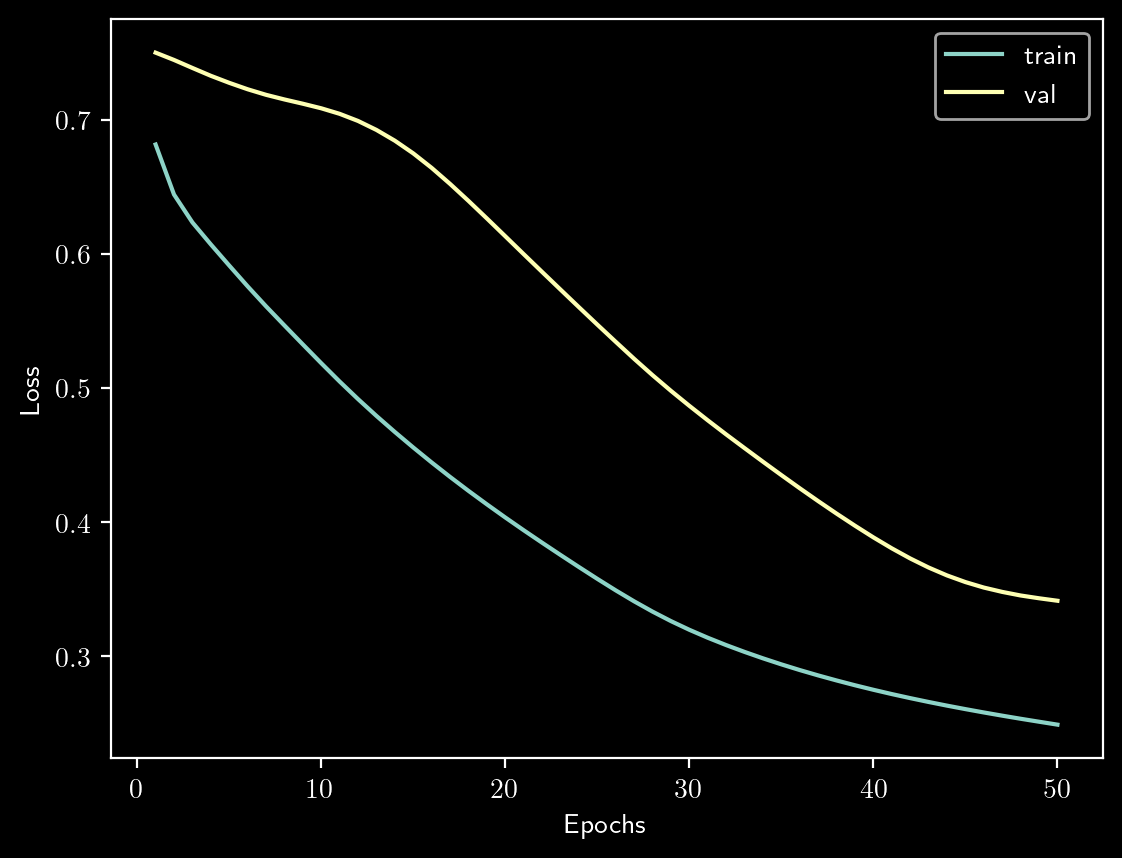

In [ ]:
epochs = np.arange(1, 51)
plt.plot(epochs, tl, label='train')
plt.plot(epochs, tt, label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

----

In [26]:
@dataclass
class ModelOptimizer:
    x_train: np.ndarray
    y_train: np.ndarray
    x_val: np.ndarray
    y_val: np.ndarray
    best_params: Dict = field(default_factory=dict)

    def objective(self, trial):
        lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
        epochs = trial.suggest_int('epochs', 10, 100)
        # batch_size = trial.suggest_int('batch_size', 4, 32)

        model = UNet(in_channels=4, out_channels=1)
        model.to(device, dtype=torch.float32)

        train_dataset = SatelliteDataset(self.x_train, self.y_train)
        val_dataset = SatelliteDataset(self.x_val, self.y_val)

        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=8)

        tl, tt = train_model(model, train_loader, val_loader, device, epochs=epochs, lr=lr)
        val_loss = tt[-1]
        # r2 = r2_score(self.y_val.flatten(), model(self.x_val).flatten().cpu().numpy())
        # print(f'val_loss: {val_loss:.4f}, r2: {r2:.4f}')
        return val_loss

    def optimize(self, n_trials):
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)
        self.best_params = study.best_params
        print(f'Best params: {self.best_params}')
        return self.best_params

In [27]:
study = ModelOptimizer(x_train=train_imgs, y_train=train_masks,
                       x_val=val_imgs, y_val=val_masks)

In [28]:
best = study.optimize(n_trials=10)

[I 2025-04-30 08:52:20,996] A new study created in memory with name: no-name-36934bd9-f98c-413d-b3cf-c667512ec9aa
[I 2025-04-30 08:52:34,083] Trial 0 finished with value: -5.152365207672119 and parameters: {'lr': 0.0072266738868203406, 'epochs': 95}. Best is trial 0 with value: -5.152365207672119.
[I 2025-04-30 08:52:43,559] Trial 1 finished with value: 0.02345026656985283 and parameters: {'lr': 0.0003442310671614237, 'epochs': 78}. Best is trial 0 with value: -5.152365207672119.
[I 2025-04-30 08:52:45,134] Trial 2 finished with value: -8.439896583557129 and parameters: {'lr': 0.0066937874171173455, 'epochs': 12}. Best is trial 2 with value: -8.439896583557129.
[I 2025-04-30 08:52:56,780] Trial 3 finished with value: -0.018211154267191887 and parameters: {'lr': 0.0006020852293604677, 'epochs': 96}. Best is trial 2 with value: -8.439896583557129.
[I 2025-04-30 08:52:59,070] Trial 4 finished with value: 0.5646000504493713 and parameters: {'lr': 0.0002599521522648678, 'epochs': 18}. Best 

Best params: {'lr': 0.0066937874171173455, 'epochs': 12}


In [29]:
model = UNet(in_channels=4, out_channels=1)
model.to(device, dtype=torch.float32)
tl,tt = train_model(model, train_loader, val_loader, device, epochs=best['epochs'], lr=best['lr'])

In [ ]:
epochs = np.arange(1, best['epochs']+1)

plt.plot(epochs, tl, label='train')
plt.plot(epochs, tt, label='val')
plt.title(f"Best params: {best}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1, 5)
plt.grid(linewidth=0.1)
plt.legend()
plt.show()